# Connect To Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
root = "drive/MyDrive/CMP/"

Mounted at /content/drive


# Local

In [1]:
root = './'

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [3]:
sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.use14corefonts'] = True

# Data Preparation

In [4]:
# Loading subtlex data
SUBTLEX_df = pd.read_excel(root+'Datasets/SUBTLEX_Zipf.xlsx')

# renaming columns for latter merge use and dropping unneccery columns
SUBTLEX_df.rename(columns={'Word':'string', 'Zipf-value': 'zipf'}, inplace=True)
SUBTLEX_df.drop(SUBTLEX_df.columns[1:-1], axis=1, inplace=True)
SUBTLEX_df.head()

,string,zipf
0,a,7.309360
1,aa,3.236317
2,aaa,2.706807
3,aah,4.721425
4,aahed,1.592864


In [5]:
SUBTLEX_df['zipf'].describe()

count    74286.000000
mean         2.479172
std          0.835829
min          1.592864
25%          1.768955
50%          2.291834
75%          2.954592
max          7.621174
Name: zipf, dtype: float64

In [6]:
def categorise_by_zipf(row):
    """
    categorizing data string as High frequency word (HF),
    Low frequency word (LF) and non-word (NW) by zipf value

    Parameters
    ----------
        row: pandas series
            pandas dataframe's row containing label and zipf column
    
    Returns:
        category (str): HF, LF, NW
    """
    category = ''
    if row['label'] == 0:
        category = 'NW'
    elif row['label'] == 1 and row['zipf'] > 3:
        category = 'HF'
    else:
        category = 'LF'
    return category

In [7]:
with open(root+'Datasets/FastText_V3/words_2M.pkl', 'rb') as f:
  words = pickle.load(f)

with open(root+'Datasets/FastText_V3/nonwords_2M.pkl', 'rb') as f:
  nonwords = pickle.load(f)

In [8]:
for w in words:
    w.insert(3, [1, 0])
    w.insert(4, 1)

for nw in nonwords:
    nw.insert(1, 0)
    nw.insert(3, [0, 1])
    nw.insert(4, 0)

In [9]:
# loading elp words and non-words as seprate dataframes
elp_words = pd.DataFrame(words, columns =['string', 'freq', 'represention', 'code', 'label'])
elp_nonwords = pd.DataFrame(nonwords, columns =['string', 'freq', 'represention', 'code', 'label'])

# mergeing elp words with subtlex words to get zipf for each elp words
# elp words that does not have zipf will be droped
elp_words = pd.merge(elp_words, SUBTLEX_df, on='string', how='left').dropna()
elp_df = pd.concat([elp_words, elp_nonwords])

# 
elp_df.fillna(0, inplace=True)
elp_df['category'] = elp_df.apply(lambda row: categorise_by_zipf(row), axis=1)
elp_df.drop_duplicates(subset=['string'], inplace=True)

In [10]:
elp_df = elp_df.sample(frac=1.0)
elp_df.head()

,string,freq,represention,code,label,zipf,category
21833,metalsmaths,0,"[-0.012346533, -0.006910196, 0.009979297, 0.01...","[0, 1]",0,0.000000,NW
33585,staggeted,0,"[-0.0065970486, -0.034333136, 0.040632084, -0....","[0, 1]",0,0.000000,NW
25311,paraded,185,"[0.0012470889, -0.0035484477, 0.01579187, -0.0...","[1, 0]",1,2.371015,LF
15904,hamsper,0,"[-0.029799474, 0.034568295, 0.04589002, 0.0361...","[0, 1]",0,0.000000,NW
10776,donate,2954,"[-0.007076242, -0.067604564, 0.09700039, 0.008...","[1, 0]",1,3.601464,HF


In [11]:
elp_df.drop_duplicates(subset=['string'], inplace=True)

In [12]:
elp_df.groupby('category').count()

,string,freq,represention,code,label,zipf
category,,,,,,
HF,14333,14333,14333,14333,14333,14333
LF,19645,19645,19645,19645,19645,19645
NW,40339,40339,40339,40339,40339,40339


In [13]:
X_train, X_test, y_train, y_test = train_test_split(np.array(list(elp_df['represention'])), elp_df['label'].to_numpy(), test_size=0.2, shuffle=True)

# Random Forest

## GridSearch

In [13]:
param_grid = { 
    'n_estimators': [100, 500],
    'max_features': ['None', 'sqrt', 'log2'],
    'max_depth' : [None, 6, 7, 8],
    'criterion' :['gini', 'entropy']
}
rf_clf = RandomForestClassifier()
rf_cv = GridSearchCV(rf_clf, param_grid, cv=5, n_jobs=7, verbose=10)
rf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\Lenovo\anaconda3\envs\cmdstan\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
80 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\envs\cmdstan\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\envs\cmdstan\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "C:\Users\Lenovo\anaconda3\envs\cmdstan\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterato

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=7,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 6, 7, 8],
                         'max_features': ['None', 'sqrt', 'log2'],
                         'n_estimators': [100, 500]},
             verbose=10)

In [14]:
print("tuned hpyerparameters :(best parameters) ", rf_cv.best_params_)
print("best accuracy :", rf_cv.best_score_)
print("mean accuracies :", rf_cv.cv_results_['mean_test_score'])

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 500}
best accuracy : 0.9833986323345381
mean accuracies : [       nan        nan 0.98316315 0.98339863 0.98052242 0.98102701
        nan        nan 0.9685297  0.96888291 0.96247448 0.96286137
        nan        nan 0.97234786 0.97229739 0.96659539 0.96715047
        nan        nan 0.97482039 0.9752409  0.97006031 0.9707163
        nan        nan 0.98279312 0.98254081 0.97961413 0.98003464
        nan        nan 0.96733549 0.96797465 0.96165031 0.96170078
        nan        nan 0.97162458 0.97184324 0.96577123 0.96619171
        nan        nan 0.97453444 0.97487085 0.97009395 0.96987532]


## Random Forest fit by best params

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 500}

In [14]:
# RF_classifier = RandomForestClassifier(n_estimators=rf_cv.best_params_['n_estimators'],
#                                        max_features=rf_cv.best_params_['max_features'],
#                                        max_depth=rf_cv.best_params_['max_depth'],
#                                        criterion=rf_cv.best_params_['criterion'],
#                                        n_jobs=-1,
#                                        verbose=1)
# RF_classifier.fit(X_train, y_train)

In [16]:
RF_classifier = RandomForestClassifier(n_estimators=500,
                                       max_features='sqrt',
                                       criterion='gini',
                                       n_jobs=-1,
                                       verbose=1)
RF_classifier.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.7min finished


RandomForestClassifier(n_estimators=500, n_jobs=-1, verbose=1)

In [17]:
acc_score = RF_classifier.score(X_test, y_test)
print(acc_score)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s


0.9847954790096879


[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.5s finished


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.7s finished


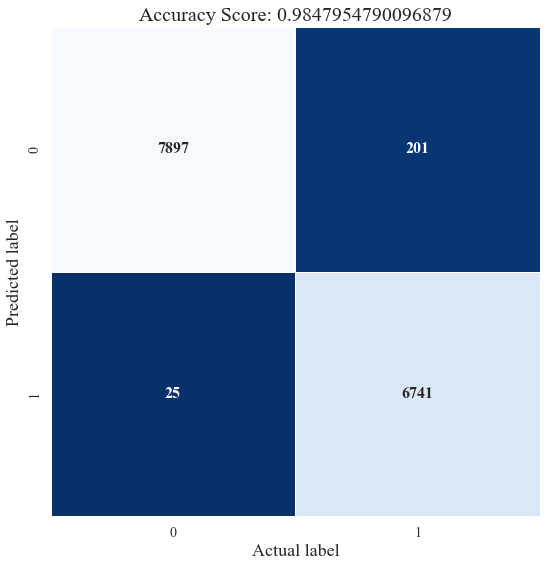

In [18]:
test_predictions = RF_classifier.predict(X_test)
cm = metrics.confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(9,9))
hm = sns.heatmap(cm, annot=True, fmt=".0f", cbar=False, linewidths=.5, square = True, cmap = 'Blues_r',
            annot_kws={
                'fontsize': 16,
                'fontweight': 'bold'
            });
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 14)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 14)
hm.set_xlabel('Actual label', fontsize=18);
hm.set_ylabel('Predicted label', fontsize=18);
all_sample_title = 'Accuracy Score: {0}'.format(acc_score)
plt.title(all_sample_title, size = 20);
plt.savefig('./Plots/Classification/RF_test_ACC.pdf')

# Get Probabilities on full dataset


In [19]:
full_predictions = RF_classifier.predict(np.array(list(elp_df['represention'])))
acc_score = RF_classifier.score(np.array(list(elp_df['represention'])), elp_df['label'].to_numpy())
print(acc_score)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    2.4s


0.9969589730478895


[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    2.8s finished


In [20]:
print(metrics.classification_report(elp_df['label'].to_numpy(), full_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.9994    0.9950    0.9972     40339
           1     0.9941    0.9993    0.9967     33978

    accuracy                         0.9970     74317
   macro avg     0.9967    0.9971    0.9969     74317
weighted avg     0.9970    0.9970    0.9970     74317



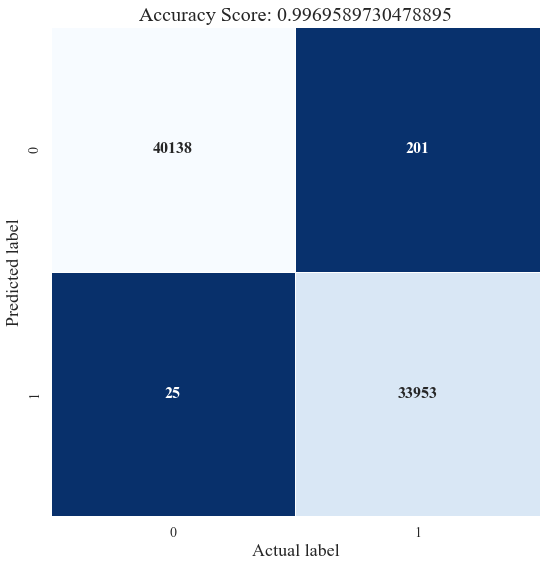

In [21]:
cm = metrics.confusion_matrix(elp_df['label'].to_numpy(), full_predictions)
plt.figure(figsize=(9,9))
hm = sns.heatmap(cm, annot=True, fmt=".0f", cbar=False, linewidths=.5, square = True, cmap = 'Blues_r',
            annot_kws={
                'fontsize': 16,
                'fontweight': 'bold'
            });
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 14)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 14)
hm.set_xlabel('Actual label', fontsize=18);
hm.set_ylabel('Predicted label', fontsize=18);
all_sample_title = 'Accuracy Score: {0}'.format(acc_score)
plt.title(all_sample_title, size = 20);
plt.savefig('./Plots/Classification/RF_full_ACC.pdf')

In [22]:
full_dataset_predictions = RF_classifier.predict_proba(np.array(list(elp_df['represention'])))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.9s finished


In [23]:
elp_df['word_prob'] = full_dataset_predictions[:,1]
elp_df['nword_prob'] = full_dataset_predictions[:,0]

In [24]:
elp_df.groupby(['category']).agg({'word_prob': ['mean', 'std', 'count', 'max', 'min'], 'nword_prob': ['mean', 'std', 'count', 'max', 'min']})

word_prob                                nword_prob                   \
              mean       std  count    max    min       mean       std  count   
category                                                                        
HF        0.966030  0.052388  14333  1.000  0.278   0.033970  0.052388  14333   
LF        0.968492  0.050261  19645  1.000  0.000   0.031508  0.050261  19645   
NW        0.025743  0.074911  40339  0.988  0.000   0.974257  0.074911  40339   

                        
            max    min  
category                
HF        0.722  0.000  
LF        1.000  0.000  
NW        1.000  0.012

In [25]:
word_df_to_save = elp_df.drop(['represention', 'code'], axis=1)

In [26]:
word_df_to_save.to_csv(root+"Datasets/fastText_RF.csv", header=0, index=False)